In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from itertools import product

In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 30)

### Optimized Portfolio of Sector Indexes

In [3]:
# list of index tickers
symbols = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU']

In [4]:
# retrieving data for each sector index
# from 2010 - 2024
# get last month (currently the last month is September) of each year
data = [
    pd.DataFrame(yf.Ticker(symbol).history(start = '2010-01-01', end = '2024-09-18', interval = '3mo'))
    .reset_index()[::-4].sort_values(by = 'Date')
    for symbol in symbols
]

# clean up index of each df - problem is that a couple sector indexes (XLC and XLRE) haven't been around since 2010 like all the other indexes so their
# data doesn't have that index, and then there's a whole mismatching thing and whatnot - this solves that
cleaned_data = [
   df.set_index(np.arange(15 - df.shape[0], 15, 1)) for df in data 
]

In [5]:
# year-to-year return series for each sector index
returns = [
    df['Close'].pct_change()
    for df in cleaned_data
]

# make return series into a dataframe to be able to run .corr() in a later step
df_returns = pd.DataFrame(returns).loc[:, np.arange(0, 15, 1)].assign(symbol = symbols).set_index('symbol').T

In [6]:
# calculate expected/mean returns
means = [
    return_.mean() # get mean return
    for return_ in returns
]

# calculate standard deviations of returns
stds = [
    return_.std() # get std dev of returns
    for return_ in returns
]

In [7]:
# make a dataframe for the important data (expected returns, standard deviations, correlations, covariances)
df = pd.DataFrame()

df['symbol'] = symbols
df['exp_return'] = means
df['std_dev'] = stds

# set index to ticker symbol
df = df.set_index('symbol')

In [8]:
# calculate correlation between each sector indexes' returns
df_corr = df_returns.corr()
# rename columns to include '_corr'
df_corr = df_corr.rename(columns = {col: col + '_corr' for col in df_corr.columns})

df = pd.concat([df, df_corr], axis = 1)

In [9]:
# each possible 2-unit combination of ticker symbols (self-pairing included) - these combinations will be used to calculate covariances based on
# standard deviations and correlations
combs = [i for i in product(symbols, repeat = 2)]

# create covariances dataframe to concatenate to main df
df_covariances = pd.DataFrame()
for symbol in symbols:
    covariances = []
    for comb in combs:
        if comb[0] == symbol:
            std1 = df.loc[comb[0]]['std_dev']
            std2 = df.loc[comb[1]]['std_dev']
            corr = df.loc[comb[0], comb[1] + '_corr']
            cov = std1 * std2 * corr
            covariances.append(cov)
    df_covariances[symbol] = covariances

# rename columns to include '_cov'
df_covariances = df_covariances.T.rename(columns = {i: symbol + '_cov' for i, symbol in zip(np.arange(0, 11, 1), symbols)})

# concat covariances to main df - this completes the main df
df = pd.concat([df, df_covariances], axis = 1)

In [10]:
df

,exp_return,std_dev,XLC_corr,XLY_corr,XLP_corr,XLE_corr,XLF_corr,XLV_corr,XLI_corr,XLB_corr,XLRE_corr,XLK_corr,XLU_corr,XLC_cov,XLY_cov,XLP_cov,XLE_cov,XLF_cov,XLV_cov,XLI_cov,XLB_cov,XLRE_cov,XLK_cov,XLU_cov
XLC,0.153768,0.239014,1.000000,0.867222,0.528625,-0.337717,0.406760,0.538027,0.708445,0.793736,0.438888,0.906955,0.021552,0.057128,0.029584,0.009679,-0.025648,0.022272,0.014470,0.025943,0.028195,0.020166,0.039157,0.000603
XLY,0.156828,0.142724,0.867222,1.000000,0.395954,-0.045638,0.569448,0.794030,0.675868,0.564032,0.400128,0.656974,-0.082355,0.029584,0.020370,0.004329,-0.002070,0.018619,0.012752,0.014779,0.011964,0.010978,0.016937,-0.001375
XLP,0.113251,0.076607,0.528625,0.395954,1.000000,-0.058799,0.445570,0.464000,0.514960,0.523144,0.858938,0.283506,0.705125,0.009679,0.004329,0.005869,-0.001431,0.007820,0.004000,0.006044,0.005956,0.012649,0.003923,0.006320
XLE,0.111801,0.317749,-0.337717,-0.045638,-0.058799,1.000000,0.470421,0.156601,0.364674,0.346154,0.127223,-0.079240,-0.038753,-0.025648,-0.002070,-0.001431,0.100964,0.034243,0.005599,0.017754,0.016346,0.007771,-0.004548,-0.001441
XLF,0.143263,0.229085,0.406760,0.569448,0.445570,0.470421,1.000000,0.654435,0.881613,0.765107,0.733749,0.418787,0.340640,0.022272,0.018619,0.007820,0.034243,0.052480,0.016870,0.030944,0.026049,0.032313,0.017330,0.009131
XLV,0.147842,0.112524,0.538027,0.794030,0.464000,0.156601,0.654435,1.000000,0.732927,0.720163,0.360556,0.585678,0.048567,0.014470,0.012752,0.004000,0.005599,0.016870,0.012662,0.012636,0.012043,0.007799,0.011904,0.000639
XLI,0.139838,0.153213,0.708445,0.675868,0.514960,0.364674,0.881613,0.732927,1.000000,0.894008,0.618686,0.608613,0.231730,0.025943,0.014779,0.006044,0.017754,0.030944,0.012636,0.023474,0.020357,0.018222,0.016844,0.004154
XLB,0.111490,0.148618,0.793736,0.564032,0.523144,0.346154,0.765107,0.720163,0.894008,1.000000,0.549846,0.724528,0.193872,0.028195,0.011964,0.005956,0.016346,0.026049,0.012043,0.020357,0.022087,0.015709,0.019450,0.003371
XLRE,0.091043,0.192237,0.438888,0.400128,0.858938,0.127223,0.733749,0.360556,0.618686,0.549846,1.000000,0.236980,0.782409,0.020166,0.010978,0.012649,0.007771,0.032313,0.007799,0.018222,0.015709,0.036955,0.008229,0.017599
XLK,0.204382,0.180635,0.906955,0.656974,0.283506,-0.079240,0.418787,0.585678,0.608613,0.724528,0.236980,1.000000,-0.094408,0.039157,0.016937,0.003923,-0.004548,0.017330,0.011904,0.016844,0.019450,0.008229,0.032629,-0.001995


In [27]:
# n samples of dirichlet distributions of weights
np.random.seed(0)
samples = np.random.dirichlet(np.ones(11), 100000) # assuming no short selling

In [28]:
# looping through each dirichlet distribution
port_exp_returns = []
port_variances = []
port_std_devs = []
for weights in samples:
    port_exp_return = np.dot( weights.T, df['exp_return'] )
    port_variance = np.dot( weights.T, np.dot( df.loc[:, [symbol + '_cov' for symbol in symbols]], weights ) )
    port_std_dev = np.sqrt(port_variance)

    port_exp_returns.append(port_exp_return)
    port_variances.append(port_variance)
    port_std_devs.append(port_std_dev)

In [29]:
# create output dataframe and fill with output data
df_output = pd.DataFrame()
df_output['port_exp_return'] = port_exp_returns
df_output['port_variance'] = port_variances
df_output['port_std_dev'] = port_std_devs

In [30]:
# calculate 'rr_ratio' column as 'std_dev' / 'exp_return' - risk-to-return ratio - we want to find the min value and its index and use that disribution
# of weights
df_output['rr_ratio'] = df_output['port_std_dev'] / df_output['port_exp_return']

In [31]:
df_output

,port_exp_return,port_variance,port_std_dev,rr_ratio
0,0.121902,0.014509,0.120455,0.988128
1,0.140767,0.013520,0.116278,0.826028
2,0.147286,0.012841,0.113318,0.769373
3,0.141932,0.014641,0.121002,0.852533
4,0.118605,0.021397,0.146278,1.233325
...,...,...,...,...
99995,0.133586,0.016980,0.130307,0.975453
99996,0.130165,0.016665,0.129092,0.991759
99997,0.149575,0.012968,0.113877,0.761336
99998,0.147017,0.023988,0.154881,1.053495


In [32]:
# find optimal portfolio allocation
optimal_rr_ratio = df_output['rr_ratio'].min()
optimal_index = df_output.loc[df_output['rr_ratio'] == optimal_rr_ratio].index
optimal_exp_return = df_output.loc[optimal_index, 'port_exp_return'].values[0]
optimal_std_dev = df_output.loc[optimal_index, 'port_std_dev'].values[0]
optimal_weights = samples[optimal_index]

In [33]:
# add 'optimal_weights' column on to main df
df['optimal_weights'] = optimal_weights[0]

__________________________________________________
Optimal Allocation Risk-to-Return Ratio: 0.6528
Standard Deviation: 0.0845
Expected Return: 0.1295
__________________________________________________


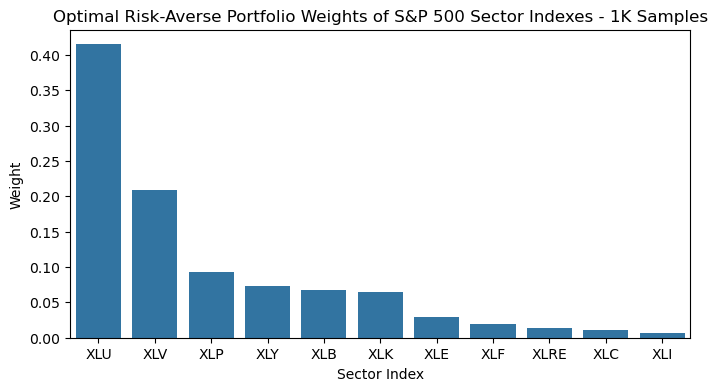

In [18]:
# visualize the final weights for 1000 samples
print('_' * 50)
print('Optimal Allocation Risk-to-Return Ratio:', round(optimal_rr_ratio, 4))
print('Standard Deviation:', round(optimal_std_dev, 4))
print('Expected Return:', round(optimal_exp_return, 4))
print('_' * 50)
df_sorted = df.sort_values(by = 'optimal_weights', ascending = False)
plt.figure(figsize = (8, 4))
sns.barplot(data = df_sorted, x = df_sorted.index, y = 'optimal_weights')
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes - 1K Samples')
plt.show()

__________________________________________________
Optimal Allocation Risk-to-Return Ratio: 0.6449
Standard Deviation: 0.083
Expected Return: 0.1287
__________________________________________________


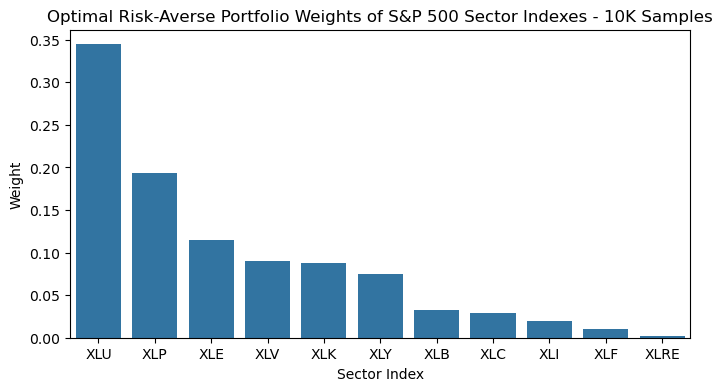

In [26]:
# visualize the final weights for 10,000 samples
print('_' * 50)
print('Optimal Allocation Risk-to-Return Ratio:', round(optimal_rr_ratio, 4))
print('Standard Deviation:', round(optimal_std_dev, 4))
print('Expected Return:', round(optimal_exp_return, 4))
print('_' * 50)
df_sorted = df.sort_values(by = 'optimal_weights', ascending = False)
plt.figure(figsize = (8, 4))
sns.barplot(data = df_sorted, x = df_sorted.index, y = 'optimal_weights')
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes - 10K Samples')
plt.show()

__________________________________________________
Optimal Allocation Risk-to-Return Ratio: 0.5895
Standard Deviation: 0.0762
Expected Return: 0.1293
__________________________________________________


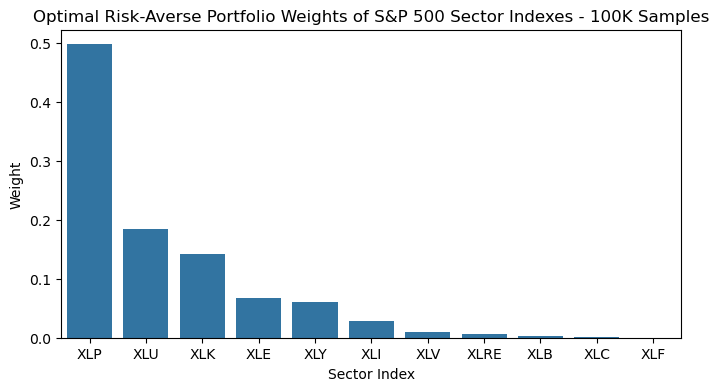

In [35]:
# visualize the final weights for 100,000 samples
print('_' * 50)
print('Optimal Allocation Risk-to-Return Ratio:', round(optimal_rr_ratio, 4))
print('Standard Deviation:', round(optimal_std_dev, 4))
print('Expected Return:', round(optimal_exp_return, 4))
print('_' * 50)
df_sorted = df.sort_values(by = 'optimal_weights', ascending = False)
plt.figure(figsize = (8, 4))
sns.barplot(data = df_sorted, x = df_sorted.index, y = 'optimal_weights')
plt.xlabel('Sector Index')
plt.ylabel('Weight')
plt.title('Optimal Risk-Averse Portfolio Weights of S&P 500 Sector Indexes - 100K Samples')
plt.show()

In [36]:
df['optimal_weights'].sort_values(ascending = False).reset_index()

,index,optimal_weights
0,XLP,0.497936
1,XLU,0.185140
2,XLK,0.142061
3,XLE,0.067696
4,XLY,0.060316
5,XLI,0.027813
6,XLV,0.009669
7,XLRE,0.005472
8,XLB,0.002721
9,XLC,0.000899
